### Caso de Estudio - Millas por Galón

Se está haciendo una investigación en la industria automotriz para mejorar el rendimiento de los motores a combustible. Para esto, se recolectó un set de datos que contiene el rendimiento (millas por galón) de distintos modelos de automóviles, así como también de los factores que se piensa influyen.

Elabore un modelo multivariado utilizando todas las variables disponibles para explicar el consumo en millas por galón.

**Nota:** Este dataset corresponde a automóviles fabricados entre 1970 y 1982. El análisis que se presenta tiene un objetivo netamente educativo y de práctica en exploración y modelado de datos, y no busca generar conclusiones aplicables al mercado actual.

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tools.eval_measures as metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### **Preparación y Limpieza de Datos**

In [3]:
# Se importan datos
columnas = ["Cilindros","Desplazamiento","Caballos_Fuerza","Peso","Aceleracion","modeloAnio","Origen","mpg","Nombre_auto"]

df = pd.read_csv("millas-por-galon.csv",skiprows=3, names=columnas)
df.head()

,Cilindros,Desplazamiento,Caballos_Fuerza,Peso,Aceleracion,modeloAnio,Origen,mpg,Nombre_auto
0,8,307.0,130.0,3504.0,12.0,70,1,18.0,chevrolet chevelle malibu
1,8,350.0,165.0,3693.0,11.5,70,1,15.0,buick skylark 320
2,8,318.0,150.0,3436.0,11.0,70,1,18.0,plymouth satellite
3,8,304.0,150.0,3433.0,12.0,70,1,16.0,amc rebel sst
4,8,302.0,140.0,3449.0,10.5,70,1,17.0,ford torino


**Nota:** La variable 'Origen' es de tipo catégorica y está codificada como:

- USA -> 1

- Europa -> 2

- Japón -> 3

In [4]:
# Se verifican los tipos de datos en las columnas y si existen valores nulos en estas.   
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Cilindros        398 non-null    int64  
 1   Desplazamiento   398 non-null    float64
 2   Caballos_Fuerza  392 non-null    float64
 3   Peso             398 non-null    float64
 4   Aceleracion      398 non-null    float64
 5   modeloAnio       398 non-null    int64  
 6   Origen           398 non-null    int64  
 7   mpg              398 non-null    float64
 8   Nombre_auto      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


In [5]:
# Se buscan las filas con valores nulos en la columna 'Caballos_Fuerza'
df[df['Caballos_Fuerza'].isna()]

,Cilindros,Desplazamiento,Caballos_Fuerza,Peso,Aceleracion,modeloAnio,Origen,mpg,Nombre_auto
32,4,98.0,NaN,2046.0,19.0,71,1,25.0,ford pinto
126,6,200.0,NaN,2875.0,17.0,74,1,21.0,ford maverick
330,4,85.0,NaN,1835.0,17.3,80,2,40.9,renault lecar deluxe
336,4,140.0,NaN,2905.0,14.3,80,1,23.6,ford mustang cobra
354,4,100.0,NaN,2320.0,15.8,81,2,34.5,renault 18i
374,4,151.0,NaN,3035.0,20.5,82,1,23.0,amc concord dl


In [6]:
# Imputación de valores faltantes en columna 'Caballos_Fuerza' usando la media por grupo de 'Cilindros'
df['Caballos_Fuerza'] = df.groupby('Cilindros')['Caballos_Fuerza'] \
                          .transform(lambda x: x.fillna(x.mean()))

In [7]:
# Se vuelven a verificar si existen valores nulos en las columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Cilindros        398 non-null    int64  
 1   Desplazamiento   398 non-null    float64
 2   Caballos_Fuerza  398 non-null    float64
 3   Peso             398 non-null    float64
 4   Aceleracion      398 non-null    float64
 5   modeloAnio       398 non-null    int64  
 6   Origen           398 non-null    int64  
 7   mpg              398 non-null    float64
 8   Nombre_auto      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


Se identificaron 6 valores nulos en la variable 'Caballos_Fuerza'. Dado que esta variable está estrechamente relacionada con la cantidad de cilindros del motor, se imputaron los valores faltantes utilizando la media del grupo correspondiente a cada categoría de cilindros. De esta manera, se preservan los registros y se mantiene la coherencia técnica entre las variables.

In [8]:
# Verificación de valores duplicados

print("Duplicados en dataset:", df.duplicated().sum())

Duplicados en dataset: 0


#### Análisis de Variables

In [9]:
# Resumen estadístico del dataset
df.describe()

,Cilindros,Desplazamiento,Caballos_Fuerza,Peso,Aceleracion,modeloAnio,Origen,mpg
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,5.454774,193.425879,104.132947,2970.424623,15.568090,76.010050,1.572864,23.514573
std,1.701004,104.269838,38.310886,846.841774,2.757689,3.697627,0.802055,7.815984
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,9.000000
25%,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,1.000000,17.500000
50%,4.000000,148.500000,92.000000,2803.500000,15.500000,76.000000,1.000000,23.000000
75%,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000,29.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,46.600000


Se obtiene un resumen estadístico de las variables numéricas. Se verifican medidas de tendencia central y dispersión, se revisan los rangos de valores y se realiza una primera detección de posibles valores atípicos o inconsistencias en los datos.

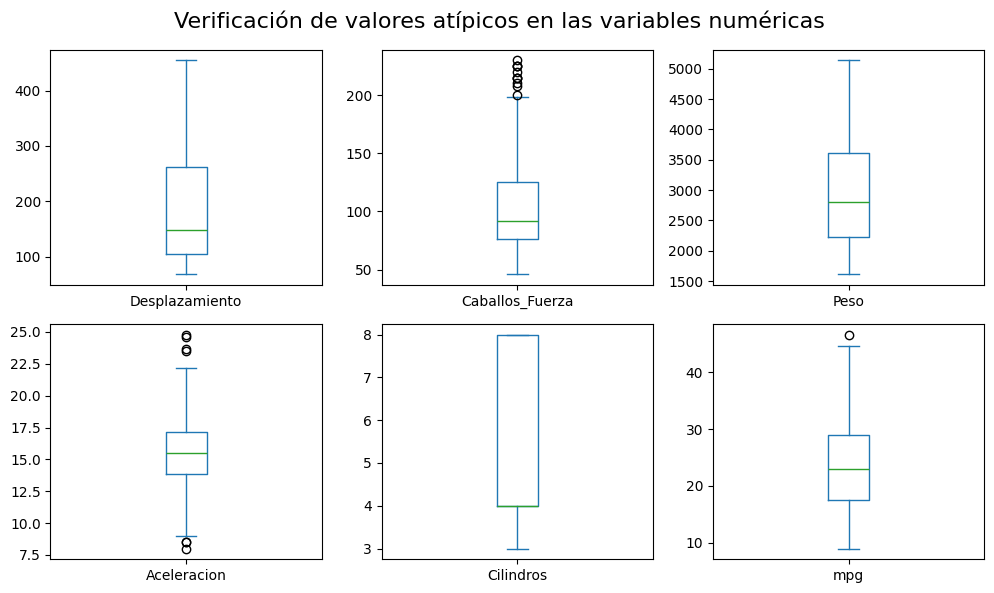

In [10]:
# Bloxplot para las variable númericas

df[['Desplazamiento','Caballos_Fuerza','Peso','Aceleracion','Cilindros', 'mpg']].plot(
    kind='box', subplots=True, layout=(2,3), figsize=(10,6)
)
plt.suptitle("Verificación de valores atípicos en las variables numéricas", fontsize=16)
plt.tight_layout()
plt.show()

El análisis mediante boxplot permitió detectar valores atípicos en Caballos de Fuerza, Aceleración y mpg. No obstante, dichos valores se encuentran dentro del rango esperable en el contexto de los datos (automóviles de distintas características), por lo que se decidió mantenerlos en el análisis. 

A continuación, se procede a visualizar las distribuciones de las variables numéricas y las relaciones entre las predictoras y la variable dependiente (mpg), con el fin de evaluar si la presencia de estos valores extremos distorsiona las relaciones y si resulta recomendable aplicar transformaciones.

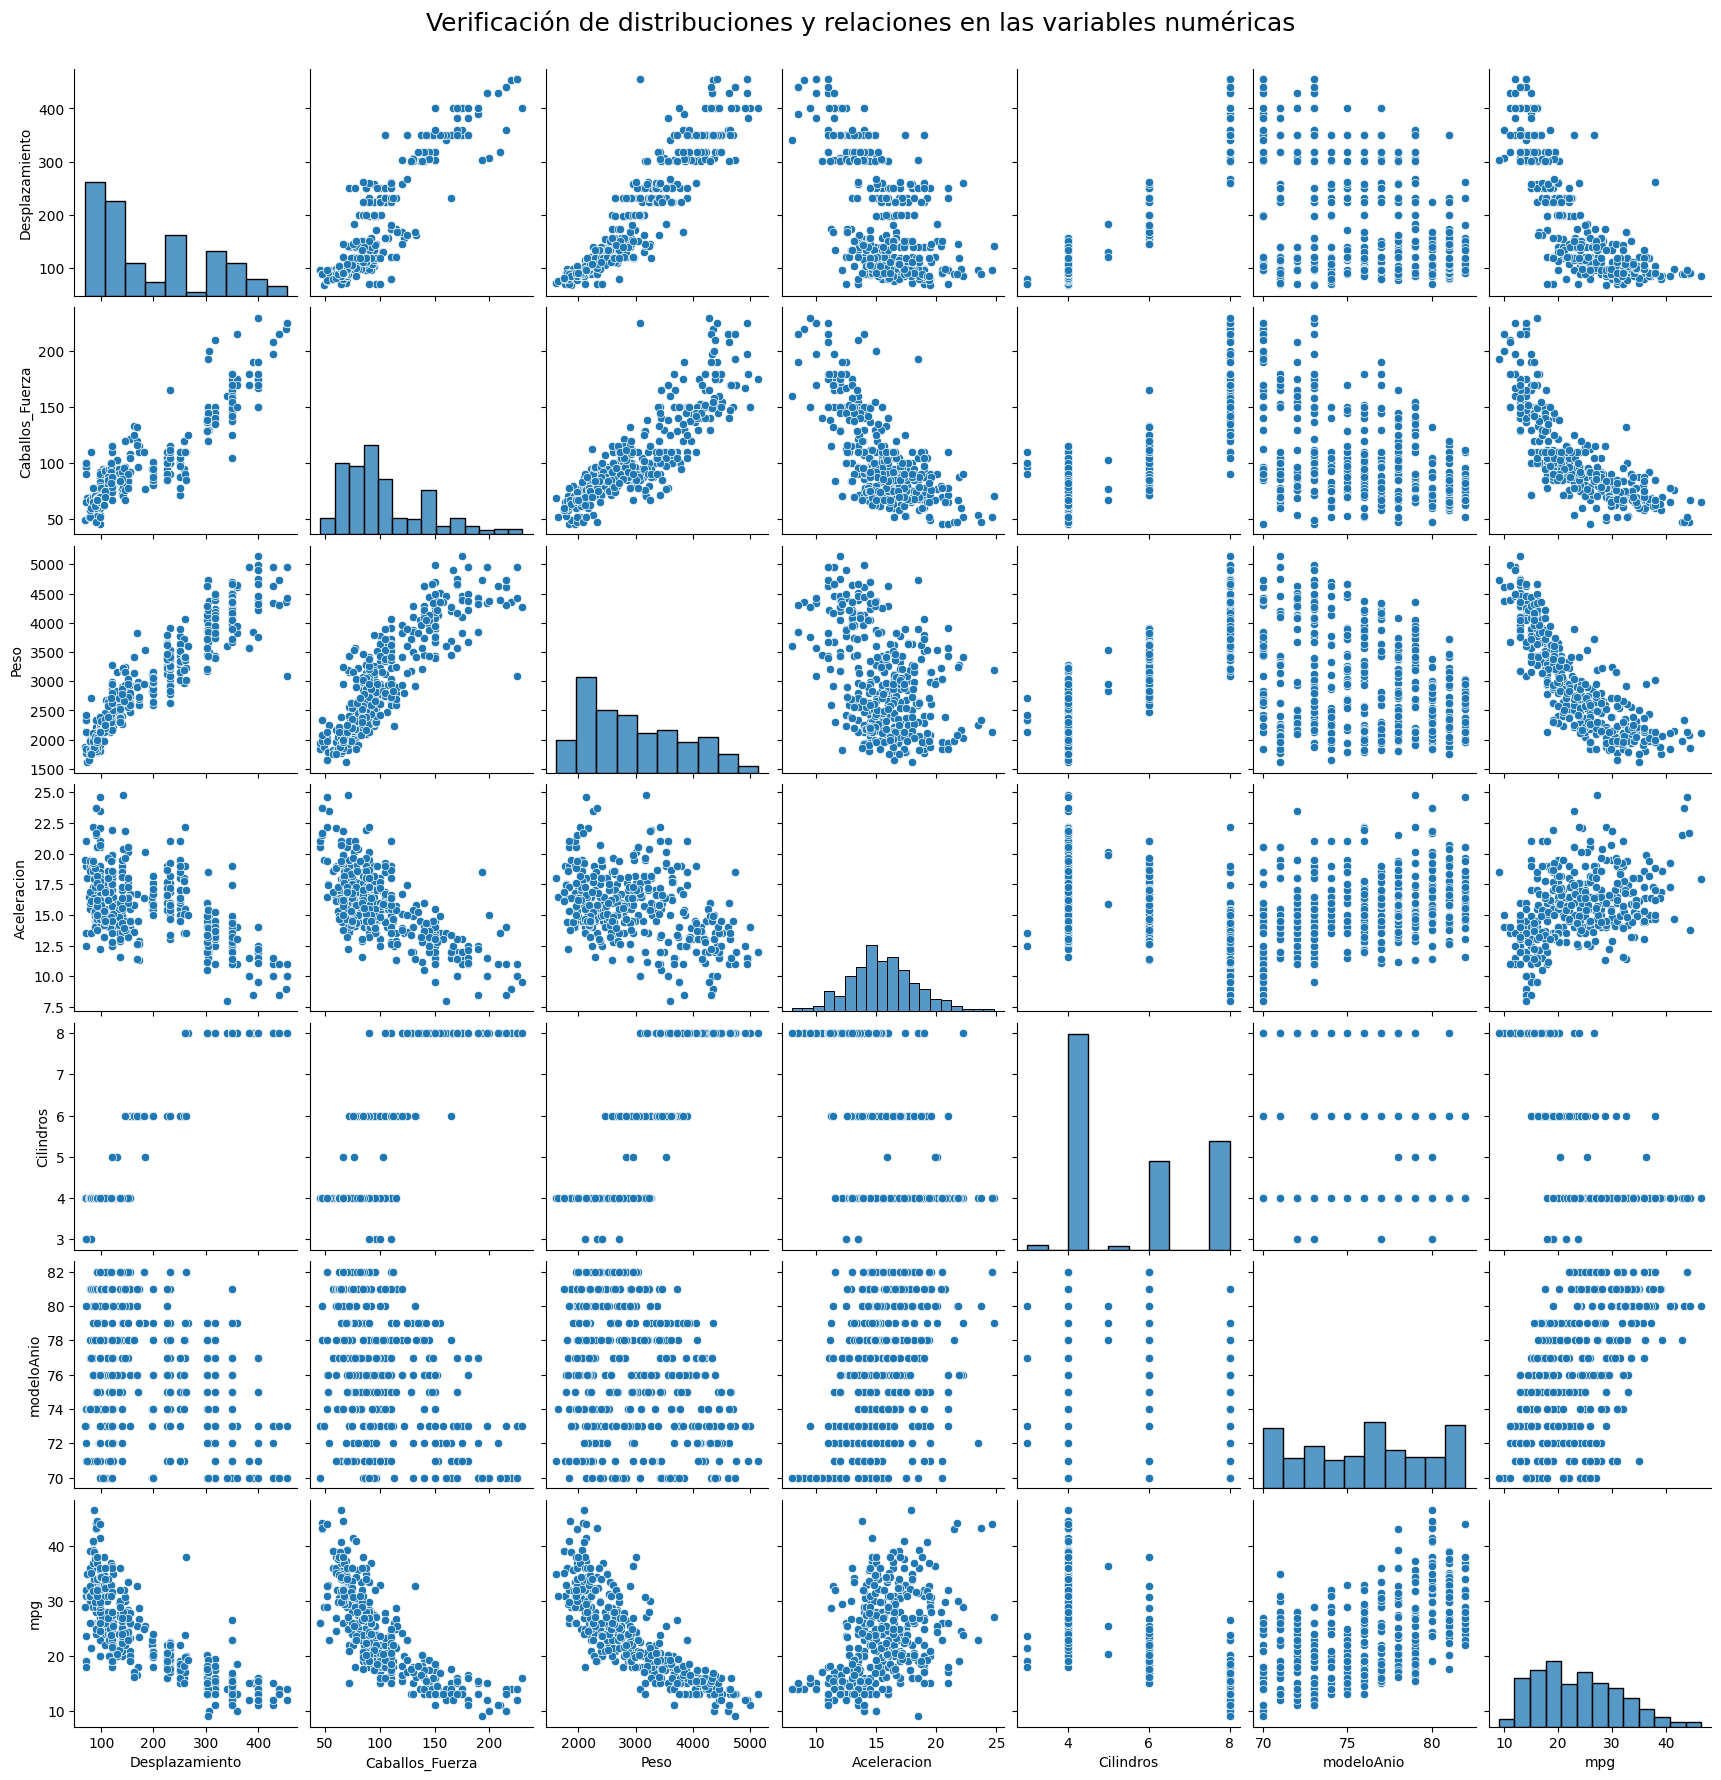

In [11]:
# Pairplot de distribuciones y relaciones en las variables númericas

pairplot = sns.pairplot(df[['Desplazamiento','Caballos_Fuerza','Peso','Aceleracion','Cilindros', 'modeloAnio', 'mpg']])
pairplot.fig.suptitle("Verificación de distribuciones y relaciones en las variables numéricas", 
               y=1.02, fontsize=18)

plt.show()

A partir del análisis de distribuciones y relaciones, se observa que las variables Caballos de Fuerza, Peso y Desplazamiento presentan un sesgo positivo importante y una alta concentración de valores en rangos elevados. Estas características podrían afectar la linealidad y la homocedasticidad en el modelo de regresión, por lo que se aplicará una transformación logarítmica a dichas variables con el fin de mitigar estas distorsiones y facilitar la interpretación de sus relaciones.

En el caso de mpg, aunque se identifican algunos valores extremos, su distribución no presenta un sesgo marcado y, al ser la variable dependiente, resulta más interpretable en su escala original; por ello, se decidió mantenerla sin transformaciones.

Por otra parte, la variable Cilindros, pese a estar registrada de forma numérica, representa categorías discretas y no una progresión lineal continua, al igual que la variable Origen. Para evitar interpretaciones incorrectas y permitir su adecuada incorporación en el modelo de regresión, ambas se transformarán en variables dummy.

Finalmente, las variables Aceleración y Año del modelo se conservarán en su forma original, dado que son numéricas continuas y no muestran problemas de sesgo importantes que justifiquen transformaciones.

In [12]:
# Se crean nuevas columnas con las transformaciones logarítmicas

df['Caballos_Fuerza(log)'] = np.log(df['Caballos_Fuerza'])
df['Peso(log)'] = np.log(df['Peso'])
df['Desplazamiento(log)'] = np.log(df['Desplazamiento'])

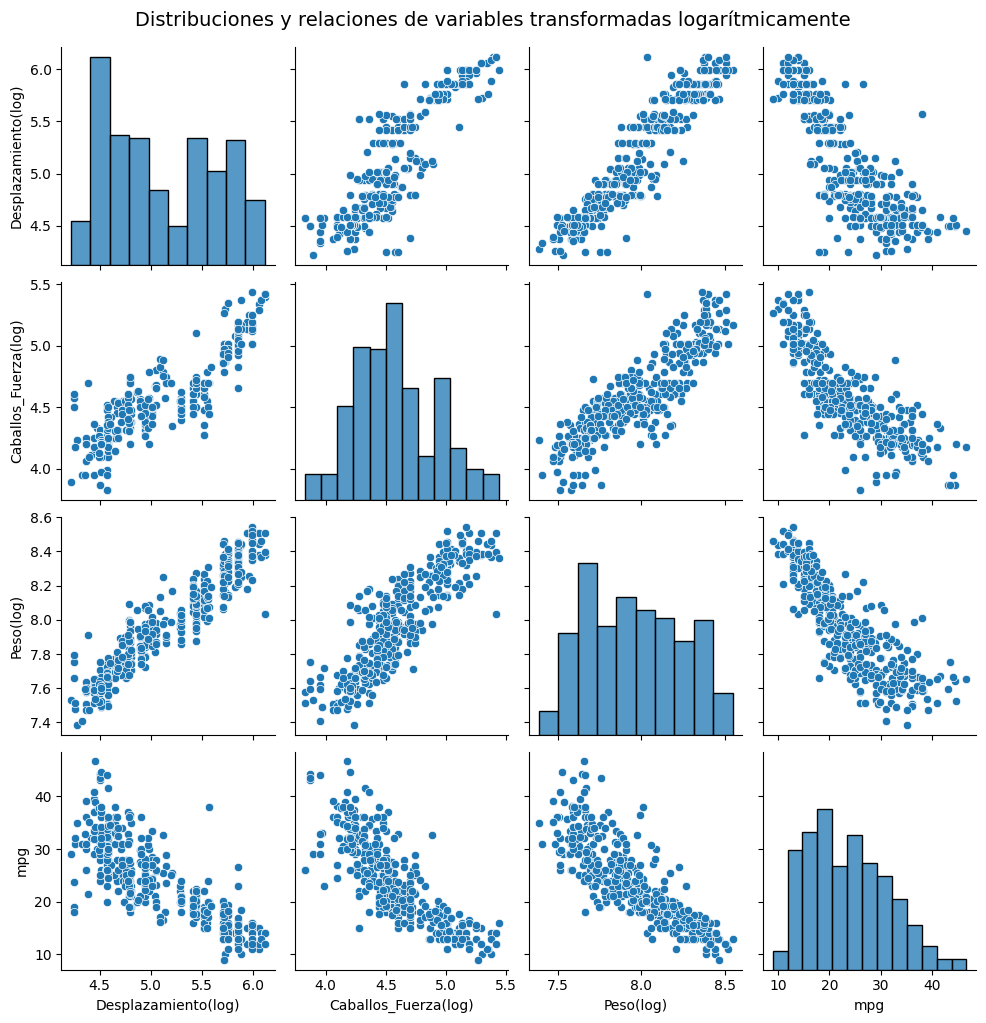

In [13]:
# Pairplot de distribuciones y relaciones de las variables transformadas logarítmicamente

pairplot_log = sns.pairplot(df[['Desplazamiento(log)','Caballos_Fuerza(log)','Peso(log)','mpg']])
pairplot_log.fig.suptitle("Distribuciones y relaciones de variables transformadas logarítmicamente", 
               y=1.02, fontsize=14)

plt.show()

Al aplicar la transformación logarítmica a las variables Caballos de Fuerza, Peso y Desplazamiento, se observa una reducción clara en la asimetría de sus distribuciones, acercándolas a una forma más normalizada. Además, las relaciones con la variable dependiente (mpg) muestran una tendencia más lineal y con menor dispersión, lo que facilita el cumplimiento de supuestos de linealidad y homocedasticidad en un modelo de regresión. De esta forma, se espera que el modelo se ajuste mejor al incorporar las variables transformadas como predictoras.

In [14]:
# Se crean las columnas dummy para la variable Cilindros
d_cil = pd.get_dummies(df['Cilindros'], prefix='Cil', prefix_sep='_', drop_first=True, dtype=int)

# Se crean las columnas dummy para la variable Origen
d_org = pd.get_dummies(df['Origen'],    prefix='Org', prefix_sep='_', drop_first=True, dtype=int)

# Concatenar al df original
df = pd.concat([df, d_cil, d_org], axis=1)

df.head()

,Cilindros,Desplazamiento,Caballos_Fuerza,Peso,Aceleracion,modeloAnio,Origen,mpg,Nombre_auto,Caballos_Fuerza(log),Peso(log),Desplazamiento(log),Cil_4,Cil_5,Cil_6,Cil_8,Org_2,Org_3
0,8,307.0,130.0,3504.0,12.0,70,1,18.0,chevrolet chevelle malibu,4.867534,8.161660,5.726848,0,0,0,1,0,0
1,8,350.0,165.0,3693.0,11.5,70,1,15.0,buick skylark 320,5.105945,8.214194,5.857933,0,0,0,1,0,0
2,8,318.0,150.0,3436.0,11.0,70,1,18.0,plymouth satellite,5.010635,8.142063,5.762051,0,0,0,1,0,0
3,8,304.0,150.0,3433.0,12.0,70,1,16.0,amc rebel sst,5.010635,8.141190,5.717028,0,0,0,1,0,0
4,8,302.0,140.0,3449.0,10.5,70,1,17.0,ford torino,4.941642,8.145840,5.710427,0,0,0,1,0,0


#### Análisis de correlaciones

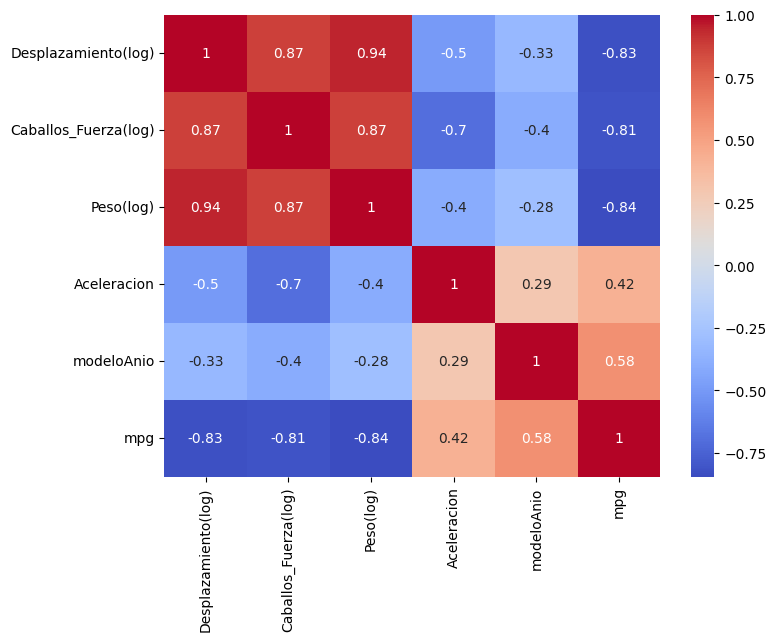

In [15]:
# Cálculo de correlaciones entre variables númericas
corr = df[['Desplazamiento(log)','Caballos_Fuerza(log)','Peso(log)','Aceleracion','modeloAnio', 'mpg']].corr()

# Heatmap de correlaciones 
plt.figure(figsize=(8, 6)) 
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

El heatmap muestra una alta correlación negativa entre la variable dependiente (mpg) y las predictoras Caballos de Fuerza (log) (-0.81), Desplazamiento (log) (-0.83) y Peso (log) (-0.84), mientras que la variable Aceleración presenta una correlación positiva moderada (0.42). Asimismo, la variable año de modelo evidencia una correlación positiva considerable (0.58) con mpg, lo que indica que los automóviles más recientes tienden a tener un mayor rendimiento de combustible.

Si bien Caballos de Fuerza, Peso y Desplazamiento presentan una fuerte relación con mpg, lo que las convierte en potenciales buenos predictores, también muestran una alta correlación entre sí (valores superiores a 0.85). Esta situación puede derivar en problemas de multicolinealidad en un modelo de regresión, afectando la estabilidad e interpretación de los coeficientes. Por ello, se procederá más adelante a calcular el Factor de Inflación de la Varianza (VIF) para evaluar formalmente el grado de multicolinealidad entre las variables y decidir si resulta conveniente excluir alguna de ellas o mantenerlas en conjunto.

In [16]:
# Cálculo del VIF

variables = df[['Desplazamiento(log)',
                'Caballos_Fuerza(log)',
                'Peso(log)',
                'Aceleracion', 
                'modeloAnio', 
                'Cil_4', 'Cil_5', 'Cil_6', 'Cil_8',
                'Org_2', 'Org_3']]

var_const = add_constant(variables)

vif = pd.DataFrame()
vif["Variable"] = var_const.columns
vif["VIF"] = [variance_inflation_factor(var_const.values, i) for i in range(var_const.shape[1])]
print(vif)

                Variable          VIF
0                  const  5112.301553
1    Desplazamiento(log)    31.711295
2   Caballos_Fuerza(log)    11.937061
3              Peso(log)    17.937562
4            Aceleracion     3.359614
5             modeloAnio     1.326462
6                  Cil_4    33.010231
7                  Cil_5     2.172900
8                  Cil_6    30.175387
9                  Cil_8    41.998592
10                 Org_2     2.020000
11                 Org_3     2.078524


El análisis del Factor de Inflación de la Varianza (VIF) confirma la presencia de un problema relevante de multicolinealidad en el conjunto de predictores. Variables como Desplazamiento(log) (VIF ≈ 31.7), Peso(log) (VIF ≈ 17.9) y Caballos_Fuerza(log) (VIF ≈ 11.9) muestran valores elevados, lo que refleja su fuerte intercorrelación. De manera similar, las variables dummies de Cilindros presentan VIF muy altos (entre 30 y 42), evidenciando redundancia informativa respecto a las variables continuas asociadas.

En este escenario, la inclusión simultánea de todos los predictores en un modelo puede generar estimaciones inestables y dificultar la interpretación de los coeficientes. Por ello, se propone avanzar con una doble estrategia de modelamiento:

- Modelo completo: incorporar todas las variables (continuas y dummies) para evaluar el máximo poder predictivo disponible.

- Modelo reducido: seleccionar un subconjunto de variables con menor colinealidad, buscando un modelo más parsimonioso y estable.

Esta comparación permitirá determinar si es posible mantener un nivel de ajuste adecuado reduciendo la complejidad del modelo, o si la incorporación de todas las variables es necesaria para maximizar el poder explicativo.

### **Modelo de Regresión Multivariado completo**

In [17]:
# Formula de modelo utilizando todas las variables
formula = 'Q("mpg") ~ Q("Desplazamiento(log)") + Q("Caballos_Fuerza(log)") + Q("Peso(log)") + Q("Aceleracion") + Q("modeloAnio") + Cil_4 + Cil_5 + Cil_6 + Cil_8 + Org_2 + Org_3'

# Ajustar el modelo
lm_full = smf.ols(formula=formula, data=df).fit()

print(lm_full.summary())

                            OLS Regression Results                            
Dep. Variable:               Q("mpg")   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     221.8
Date:                Wed, 24 Sep 2025   Prob (F-statistic):          2.74e-159
Time:                        09:34:56   Log-Likelihood:                -986.41
No. Observations:                 398   AIC:                             1997.
Df Residuals:                     386   BIC:                             2045.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [18]:
# Coeficientes estimados del modelo
print(lm_full.params)

Intercept                    101.256848
Q("Desplazamiento(log)")      -0.866031
Q("Caballos_Fuerza(log)")     -5.771876
Q("Peso(log)")               -13.455896
Q("Aceleracion")              -0.179763
Q("modeloAnio")                0.726766
Cil_4                          7.260868
Cil_5                          8.725664
Cil_6                          6.083834
Cil_8                          8.423185
Org_2                          1.104344
Org_3                          1.703088
dtype: float64


El modelo de regresión múltiple que incluye todas las variables seleccionadas alcanza un R² de 0.863 (R² ajustado: 0.860), lo que indica que explica aproximadamente el 86% de la variabilidad del consumo de combustible (mpg). Este nivel de ajuste es elevado, mostrando que el conjunto de predictores en su totalidad tiene un buen poder explicativo.

Al analizar los coeficientes, se observa que el peso (log) y los caballos de fuerza (log) presentan efectos negativos y estadísticamente significativos sobre el mpg, confirmando que a mayor peso y potencia del vehículo, menor eficiencia en el consumo de combustible. En contraste, el año del modelo muestra una relación positiva y significativa, lo que refleja una mejora progresiva en la eficiencia a lo largo del tiempo. Asimismo, las variables dummy asociadas a la cantidad de cilindros (4, 5, 6 y 8) resultan significativas, indicando que el número de cilindros constituye un factor diferenciador en el rendimiento de los automóviles.

En cuanto al origen del vehículo, tomando a Estados Unidos (Org_1) como categoría de referencia, los coeficientes muestran que los autos europeos (Org_2) presentan en promedio +1.10 mpg respecto a los estadounidenses, mientras que los japoneses (Org_3) presentan +1.70 mpg. Esto sugiere que, controlando por las demás variables, los vehículos europeos y japoneses tendían a ser más eficientes en el consumo de combustible que los estadounidenses.

No obstante, el número de condición elevado (5.7e+03) junto con los valores altos de VIF obtenidos previamente, sugieren la presencia de multicolinealidad severa, especialmente entre las variables relacionadas con la potencia, peso y cilindrada. Esto implica que, si bien el modelo presenta un ajuste global satisfactorio, la interpretación de los coeficientes individuales debe realizarse con cautela, dado que la multicolinealidad puede distorsionar las estimaciones.

In [19]:
# Cálculo de metricas de error

y_real = df["mpg"]
y_pred_lm_full =  lm_full.predict(df)

mae = metrics.meanabs(y_real, y_pred_lm_full)
mse = metrics.mse(y_real, y_pred_lm_full)
rmse = metrics.rmse(y_real, y_pred_lm_full)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Medium Squared Error: {rmse:.2f}")

Mean Absolute Error: 2.12
Mean Squared Error: 8.32
Root Medium Squared Error: 2.88


Las métricas de desempeño del modelo de regresión multivariada con todas las variables muestran un MAE de 2.12 mpg, un MSE de 8.32 y un RMSE de 2.88 mpg. Estos valores indican que, en promedio, el modelo presenta un error de predicción cercano a 2–3 mpg, lo cual representa un nivel de precisión aceptable considerando que el rango de la variable dependiente oscila entre aproximadamente 10 y 45 mpg.

En consecuencia, el modelo logra capturar adecuadamente la variación en el consumo de combustible, aunque los elevados valores de VIF evidencian problemas de multicolinealidad que pueden estar afectando la interpretación de los coeficientes. Esto refuerza la decisión metodológica de comparar este modelo completo con otro que utilice una selección reducida de predictores.

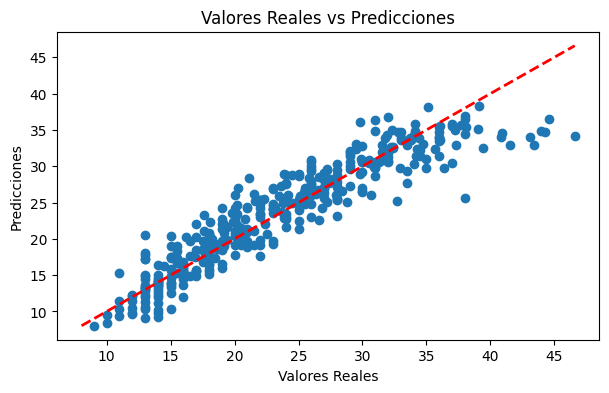

In [20]:
# Gráfico de dispersión entre valores reales y predicciones del modelo construido
plt.figure(figsize=(7,4))
plt.scatter(y_real,y_pred_lm_full, label="Datos")

# Línea de regresión
lim_inf = min(y_real.min(), y_pred_lm_full.min())
lim_sup = max(y_real.max(), y_pred_lm_full.max())
plt.plot([lim_inf, lim_sup], [lim_inf, lim_sup],
         "r--", linewidth=2, label="Línea 1:1")

plt.title('Valores Reales vs Predicciones')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

El gráfico de dispersión entre los valores reales y las predicciones muestra que el modelo full logra capturar de manera adecuada la relación entre las variables independientes y el consumo de combustible (mpg). La mayoría de los puntos se alinean en torno a la línea de referencia 1:1, lo que refleja una buena capacidad predictiva. 

Este resultado es consistente con las métricas de error MAE (2.12) y RMSE (2.88). En conjunto, tanto las métricas como la visualización confirman que el modelo ofrece un buen desempeño global para explicar y predecir el consumo de combustible. No obstante, se observa una ligera tendencia a errores mayores en los vehículos con consumos más altos, lo que sugiere que el modelo podría mejorar si se ajustan las variables o se reduce la multicolinealidad detectada.

#### Análisis de residuos del modelo completo

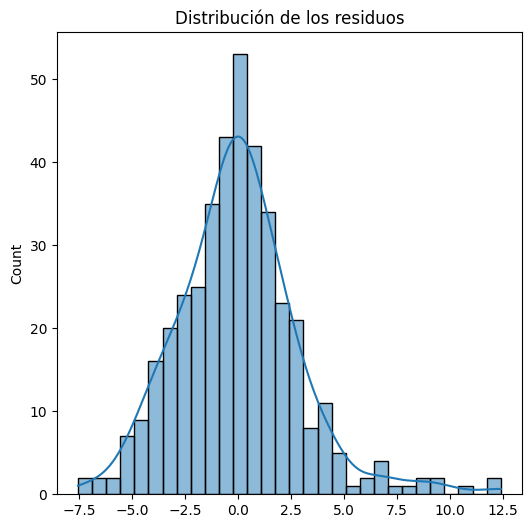

In [21]:
# Histograma de los residuos
residuos_lm_full = y_real - y_pred_lm_full

plt.figure(figsize=(6, 6)) 
sns.histplot(residuos_lm_full, kde=True, bins=30)
plt.title("Distribución de los residuos")
plt.show()

El análisis de la distribución de los residuos muestra que estos se concentran alrededor de cero y presentan una forma aproximadamente simétrica, lo cual sugiere que el modelo no incurre en un sesgo sistemático en sus predicciones. Aunque se observa cierta desviación en las colas, el comportamiento general de los residuos es coherente con el supuesto de normalidad, apoyando la validez del modelo como herramienta predictiva.

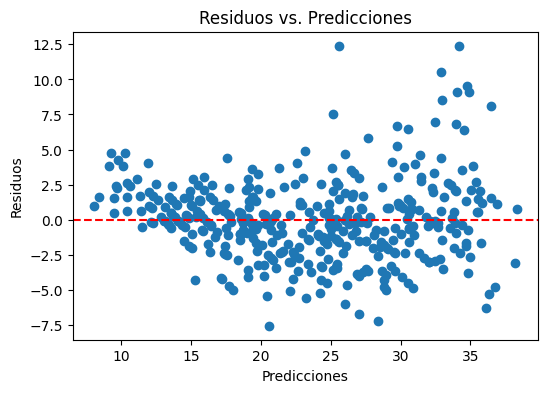

In [22]:
# Grafico de dispersión de Residuos vs. Predicciones
plt.figure(figsize=(6,4))
plt.scatter(y_pred_lm_full, residuos_lm_full)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Residuos vs. Predicciones")
plt.show()

El gráfico de residuos frente a predicciones muestra que los errores se distribuyen sin un patrón definido alrededor de cero, lo que indica que el modelo no presenta un sesgo sistemático en sus estimaciones. Además, la variabilidad de los residuos es relativamente constante a lo largo del rango de predicciones, apoyando el supuesto de homocedasticidad. No obstante, se aprecia una dispersión ligeramente mayor en los valores extremos de mpg, lo que sugiere que el modelo podría tener menor precisión en casos atípicos o en los extremos de la distribución.

### **Modelo de regresión multivariado reducido**

Tras evaluar el modelo completo y los indicadores de multicolinealidad (VIF), se optó por construir un modelo reducido con un subconjunto de variables seleccionadas. El criterio principal fue mantener aquellas variables que aportan información relevante al poder explicativo del modelo, pero evitando redundancias y problemas derivados de la alta correlación entre predictores.

En el modelo inicial, las variables relacionadas con las características mecánicas del vehículo, desplazamiento, caballos de fuerza, peso y número de cilindros, mostraron fuertes correlaciones entre sí y VIF elevados (superiores a 10 e incluso cercanos a 40 en el caso de los cilindros). Esto confirma la presencia de multicolinealidad severa, lo que dificulta la interpretación confiable de los coeficientes individuales.

Dado este escenario, se decidió:

- Mantener el peso (log): representa de manera global la influencia de la masa del vehículo en el consumo, y resume gran parte de la información que también reflejan cilindros, caballos de fuerza y desplazamiento.

- Mantener el año del modelo: presenta baja multicolinealidad y capta la evolución tecnológica y mejoras en eficiencia a lo largo del tiempo.

- Mantener el origen: con VIF bajos, permite capturar diferencias estructurales en la eficiencia entre automóviles de EE. UU., Europa y Japón.

En contraste, se descartaron:

- Desplazamiento (log), caballos de fuerza (log) y cilindros, ya que, pese a ser significativos en el modelo completo, aportan información redundante que genera distorsiones en la estimación de los coeficientes debido a la alta colinealidad con el peso.

- Aceleración, dado que su coeficiente no resultó estadísticamente significativo (valor p elevado), indicando que no aporta información relevante al modelo.

Con esta selección, el modelo reducido busca un equilibrio entre un buen ajuste e interpretabilidad, manteniendo las variables más representativas y evitando problemas estadísticos derivados de la multicolinealidad.

In [29]:
# Formula de modelo reducido
formula_2 = 'Q("mpg") ~ Q("Peso(log)") + Q("modeloAnio") + Org_2 + Org_3'

# Ajustar el modelo
lm_reducido = smf.ols(formula=formula_2, data=df).fit()

print(lm_reducido.summary())

                            OLS Regression Results                            
Dep. Variable:               Q("mpg")   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     529.3
Date:                Wed, 24 Sep 2025   Prob (F-statistic):          9.52e-157
Time:                        09:36:58   Log-Likelihood:                -1013.6
No. Observations:                 398   AIC:                             2037.
Df Residuals:                     393   BIC:                             2057.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         113.4120      7.497     

Los resultados muestran que el modelo reducido alcanza un R² de 0.843 (R² ajustado: 0.842), lo que implica una pérdida mínima de capacidad explicativa (≈2%) respecto al modelo completo (R² de 0.863). Además, todos los coeficientes resultan estadísticamente significativos y presentan la dirección esperada: los autos más pesados consumen más, los modelos más recientes son más eficientes y los autos europeos y japoneses muestran un mejor rendimiento que los estadounidenses.

Aunque el número de condición del modelo reducido (3.7e+03) sigue siendo relativamente elevado, la multicolinealidad es mucho menor que en el modelo completo, mejorando la interpretabilidad de los resultados.

In [30]:
# Cálculo de metricas de error

y_real = df["mpg"]
y_pred_lm_reducido =  lm_reducido.predict(df)

mae = metrics.meanabs(y_real, y_pred_lm_reducido)
mse = metrics.mse(y_real, y_pred_lm_reducido)
rmse = metrics.rmse(y_real, y_pred_lm_reducido)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Medium Squared Error: {rmse:.2f}")

Mean Absolute Error: 2.30
Mean Squared Error: 9.54
Root Medium Squared Error: 3.09


Al comparar los resultados de error entre el modelo completo y el modelo reducido se observa que el modelo completo presenta valores más bajos en todas las métricas (MAE = 2.12, MSE = 8.32, RMSE = 2.88) en comparación con el modelo reducido (MAE = 2.30, MSE = 9.54, RMSE = 3.09). Esto indica que el modelo completo tiene un mejor desempeño predictivo, logrando menores desviaciones promedio entre los valores observados y los predichos.

No obstante, la diferencia en los errores es relativamente pequeña, lo que muestra que el modelo reducido, a pesar de descartar variables, mantiene un nivel de predicción bastante cercano al del modelo completo.

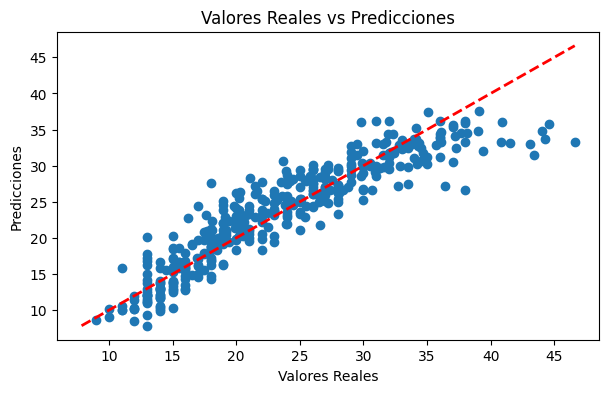

In [25]:
# Gráfico de dispersión entre valores reales y predicciones del modelo reducido
plt.figure(figsize=(7,4))
plt.scatter(y_real,y_pred_lm_reducido, label="Datos")

# Línea de regresión
lim_inf = min(y_real.min(), y_pred_lm_reducido.min())
lim_sup = max(y_real.max(), y_pred_lm_reducido.max())
plt.plot([lim_inf, lim_sup], [lim_inf, lim_sup],
         "r--", linewidth=2, label="Línea 1:1")

plt.title('Valores Reales vs Predicciones')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

El gráfico muestra que, en general, los valores predichos por el modelo reducido se ajustan adecuadamente a los valores reales, evidenciando una buena capacidad de representación. Al igual que en el modelo completo, se observa una ligera desviación en las predicciones cuando los valores aumentan, lo que indica que el modelo tiende a perder precisión en los rangos más altos. Aun así, el ajuste global es consistente y comparable con el obtenido en el modelo completo.

#### Análisis de residuos del modelo completo

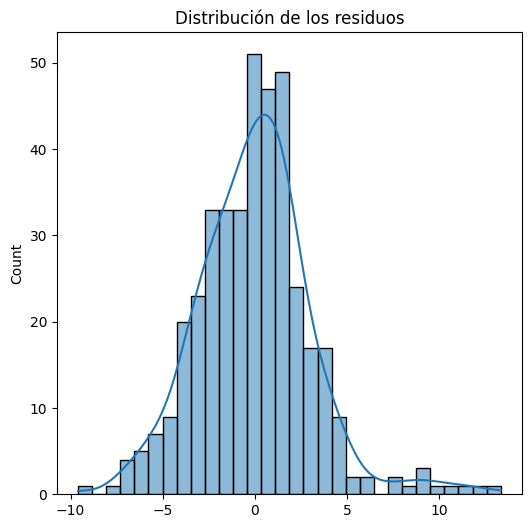

In [26]:
# Histograma de los residuos
residuos_lm_reducido = y_real - y_pred_lm_reducido

plt.figure(figsize=(6, 6)) 
sns.histplot(residuos_lm_reducido, kde=True, bins=30)
plt.title("Distribución de los residuos")
plt.show()

El histograma de los residuos del modelo reducido muestra una distribución aproximadamente normal, con forma de campana, aunque la concentración en torno a 0 no es tan marcada como en el modelo completo. Al igual que en este último, se observa una cola más larga hacia la derecha, lo que indica cierta asimetría positiva en los errores. En conjunto, la distribución sigue siendo razonablemente adecuada para los supuestos del modelo, aunque con un ajuste ligeramente menos preciso que en el modelo completo.

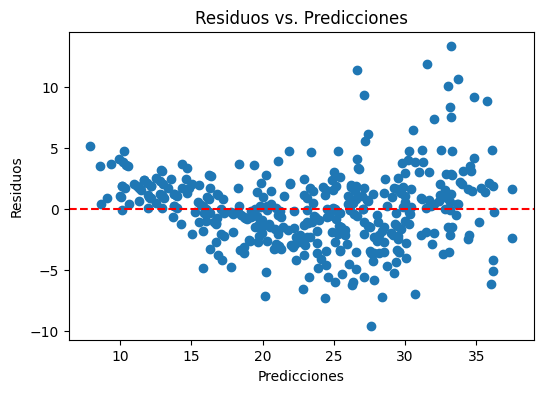

In [27]:
# Grafico de dispersión de Residuos vs. Predicciones
plt.figure(figsize=(6,4))
plt.scatter(y_pred_lm_reducido, residuos_lm_reducido)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Residuos vs. Predicciones")
plt.show()

La gráfica de dispersión de residuos frente a los valores predichos en el modelo reducido muestra un patrón similar al del modelo completo. Los residuos se distribuyen de manera aleatoria en torno a la línea de cero, lo que indica que no existe un sesgo sistemático importante en las predicciones. Sin embargo, se observa, al igual que en el modelo completo, una ligera mayor dispersión de los errores a medida que aumentan los valores predichos, lo que sugiere que el modelo tiene menor precisión en el rango superior de las predicciones.

### **Conclusiones**

El análisis comparativo entre el modelo completo y el modelo reducido permite obtener varias observaciones relevantes:

- Ajuste global (R²):
El modelo completo presentó un ajuste ligeramente superior al reducido, explicando mejor la variabilidad del consumo de combustible (mpg). Esto era esperable, dado que incluye un mayor número de variables.

- Errores de predicción:
El modelo completo obtuvo mejores métricas de error (MAE: 2.12; RMSE: 2.88) en comparación con el reducido (MAE: 2.30; RMSE: 3.09). Aunque las diferencias no son muy grandes, indican que el modelo completo predice con mayor precisión.

- Supuestos del modelo:
En ambos casos, los gráficos de valores reales vs. predichos y de residuos vs. predicciones muestran un buen comportamiento general, aunque con cierta pérdida de precisión en valores altos. El histograma de los residuos indica en ambos modelos una distribución cercana a la normal, con ligera asimetría hacia la derecha. Sin embargo, el modelo reducido muestra una concentración menos marcada en torno a 0.

- Multicolinealidad y simplicidad:
El modelo completo presentaba problemas de multicolinealidad entre varias variables, lo que puede complicar la interpretación de los coeficientes. En cambio, el modelo reducido, al quedarse con Peso (log), Año del modelo y Origen, resulta más parsimonioso y fácil de interpretar, sacrificando solo una pequeña parte de precisión.

**¿Qué modelo elegir?**

- Si el objetivo es lograr la máxima precisión predictiva y no resulta prioritario interpretar la relación entre variables, el modelo completo es el más adecuado.

- Si se busca un modelo más interpretable, robusto y con menor riesgo de multicolinealidad, el modelo reducido resulta más conveniente, especialmente en contextos donde la simplicidad y la claridad de la relación entre variables es prioritaria.

En síntesis, ambos modelos son válidos: la elección dependerá del equilibrio deseado entre precisión y simplicidad/interpretabilidad, según el contexto de aplicación.